# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
#method to easy exchange distance measure methods
def calcDistanceWith(D,distance_measure):
    for i in range(0,np.shape(movies)[0]):
        for j in range(0,np.shape(movies)[0]):
            if i!=j:
                D[i,j]=distance_measure(R[:,i],R[:,j])

In [4]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [5]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_cosine=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
calcDistanceWith(D_cosine,CosineDist)

Wall time: 1min 8s


In [6]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [7]:
CII("Casablanca",D_cosine)

recommending movies for: 'Casablanca (1942)'


133                                  Citizen Kane (1941)
131                             Wizard of Oz, The (1939)
483                           Maltese Falcon, The (1941)
473    Dr. Strangelove or: How I Learned to Stop Worr...
134                         2001: A Space Odyssey (1968)
Name: title, dtype: object

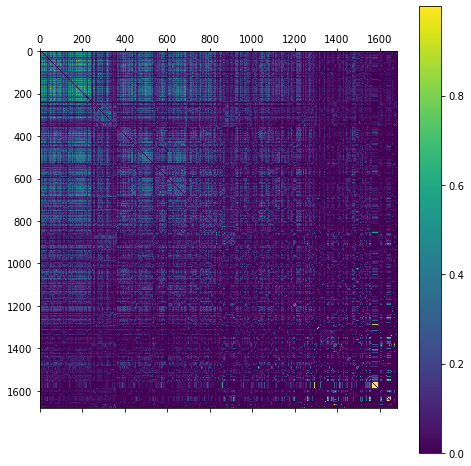

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_cosine)
plt.colorbar()

In [9]:
def EucledianDist(a,b):
    return np.linalg.norm(b-a)

In [10]:
D_eucledian=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
calcDistanceWith(D_eucledian,EucledianDist)

In [11]:
CII("Casablanca",D_eucledian)

recommending movies for: 'Casablanca (1942)'


257          Contact (1997)
299    Air Force One (1997)
312          Titanic (1997)
287           Scream (1996)
49         Star Wars (1977)
Name: title, dtype: object

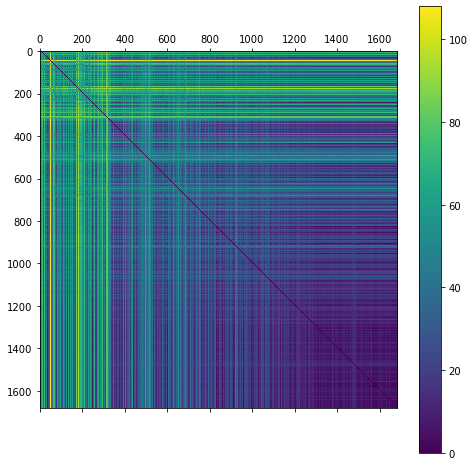

In [12]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_eucledian)
plt.colorbar() 

## Result
Die älteren Filme haben mehr Bewertungen gesamt. Aus diesem Grund erhöht sich die euklidische Distanz, obwohl sich die Ähnlichkeit kaum verändert.
Die Cosinus-Distanz bringt Abhilfe, da sie diese Eigenschaft ignoriert. (Vergleiche Schaubilder)

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

#### Random recommendations

In [13]:
C=np.zeros(np.shape(movies)[0])
for i in range(np.shape(movies)[0]):
    C[i]=ratings['movie_id'][i]-1
getNameByID(np.random.choice(C,5))

120                    Independence Day (ID4) (1996)
31                                      Crumb (1994)
303                             Fly Away Home (1996)
648               Once Upon a Time in America (1984)
226    Star Trek VI: The Undiscovered Country (1991)
Name: title, dtype: object

#### Top 5 Movies

In [14]:
# Create movie rating by average matrix A
A=np.zeros(np.shape(movies)[0])
for i in range(0,np.shape(movies)[0]):
    A[i]=np.mean(R[:,i])#R[:,i].sum()/np.shape(users)[0]
A

array([1.85896076, 0.44538706, 0.28950159, ..., 0.00212089, 0.00318134,
       0.00318134])

In [15]:
# Return 5 best rated movies by average
getNameByID(A.argsort()[-5:])[::-1]

49                   Star Wars (1977)
99                       Fargo (1996)
180         Return of the Jedi (1983)
257                    Contact (1997)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

#### Result
Bei der zufälligen Recommendation können möglicherweise interessante Filme vorschlagen werden. Die Diversität ist sehr hoch und es werden wahrscheinlich häufiger neue Filme vorgeschlagen.<br>

Bei den Top-5-Filmen von allen Usern ist die Diversität sehr gering, da so gut wie immer schon bekannte Filme vorgeschlagen werden. Da diese Filme sehr beliebt sind, kann
es natürlich sein, dass die Filme häufiger angeschaut werden.

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


array([1.92975815e+02, 5.07954112e+01, 4.48492793e+01, ...,
       4.84719784e-03, 3.25223840e-03, 8.77128853e-05])

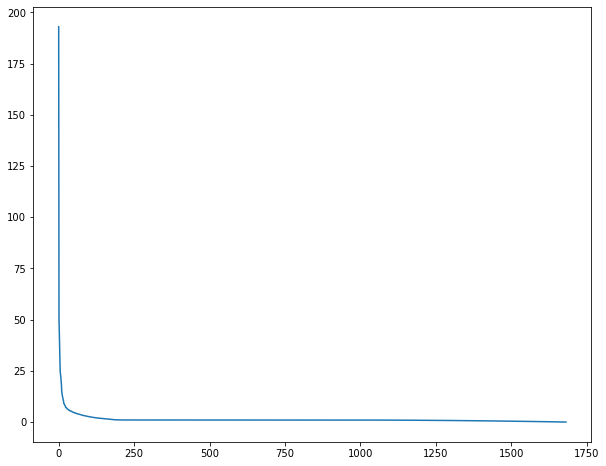

In [16]:
D=D_cosine

U,S,V=np.linalg.svd(D)

# plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig, axes = plt.subplots()
axes.plot(S)
# axes.set_ylim([0, 25])
# axes.set_xlim([0, 50])
S

In [17]:
mask = (S > 10)
#mask

In [18]:
indices =np.where(mask)
#indices

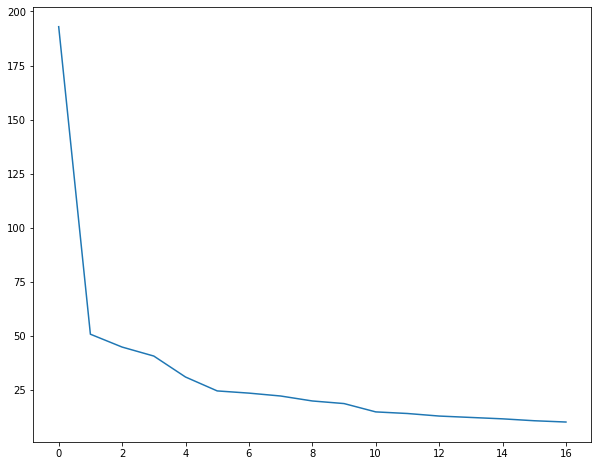

In [19]:
fig, axes = plt.subplots()
axes.plot(S[indices])

In [20]:
#D_svd=np.dot(U[:,indices]*S[indices],V[indices,:])
D_svd=np.dot(U[:,:np.shape(S[indices])[0]]*S[:np.shape(S[indices])[0]],V[:np.shape(S[indices])[0],:])
D_svd

array([[ 0.61559443,  0.41158611,  0.32617127, ..., -0.01345716,
         0.03070358,  0.03483063],
       [ 0.41158611,  0.53874082,  0.29183533, ...,  0.00704544,
         0.06727354,  0.04193249],
       [ 0.32617127,  0.29183533,  0.33855848, ..., -0.00700032,
         0.04532564,  0.06438841],
       ...,
       [-0.01345716,  0.00704544, -0.00700032, ...,  0.06425314,
         0.00801757, -0.00713298],
       [ 0.03070358,  0.06727354,  0.04532564, ...,  0.00801757,
         0.02546526,  0.01525317],
       [ 0.03483063,  0.04193249,  0.06438841, ..., -0.00713298,
         0.01525317,  0.02947313]])

In [21]:
# D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
# D=D_svd
print(np.shape(D_svd))
print(np.shape(D_cosine))

(1682, 1682)
(1682, 1682)


In [22]:
CII("Casablanca",D_svd)

recommending movies for: 'Casablanca (1942)'


173    Raiders of the Lost Ark (1981)
134      2001: A Space Odyssey (1968)
482                 Casablanca (1942)
190                    Amadeus (1984)
203         Back to the Future (1985)
Name: title, dtype: object

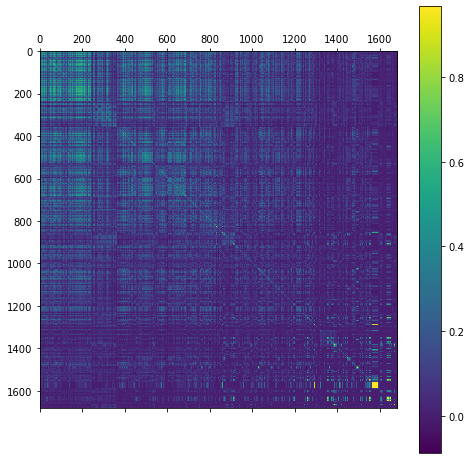

In [23]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_svd)
plt.colorbar() 

### Result
Die Distanzmatrix mit der Sigular Value Decomposition $D'$ erziehlt ähnliche Ergebnisse, wie die normale Cosinus-Disstanzmatrix $D'$. 

### Evaluierung

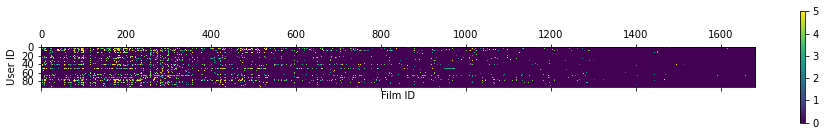

In [24]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
plt.matshow(R_test)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [25]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D_train=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_train[i,j]=CosineDist(R_train[:,i],R_train[:,j])

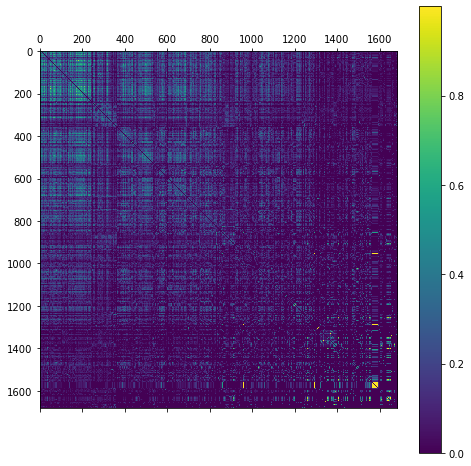

In [26]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_train)
plt.colorbar()

In [27]:
U,S,V=np.linalg.svd(D_train)

In [28]:
mask = (S > 10)
#mask

In [29]:
indices =np.where(mask)
#indices

In [30]:
D_svd_train=np.dot(U[:,:np.shape(S[indices])[0]]*S[:np.shape(S[indices])[0]],V[:np.shape(S[indices])[0],:])
D_svd_train

array([[ 0.60703612,  0.39826402,  0.32488603, ..., -0.01138548,
         0.03104045,  0.03382063],
       [ 0.39826402,  0.53550269,  0.27821005, ...,  0.00602961,
         0.07072042,  0.04503414],
       [ 0.32488603,  0.27821005,  0.33055006, ..., -0.00637305,
         0.04629965,  0.0636625 ],
       ...,
       [-0.01138548,  0.00602961, -0.00637305, ...,  0.07225982,
         0.00792721, -0.0065639 ],
       [ 0.03104045,  0.07072042,  0.04629965, ...,  0.00792721,
         0.02807787,  0.01773043],
       [ 0.03382063,  0.04503414,  0.0636625 , ..., -0.0065639 ,
         0.01773043,  0.0360487 ]])

In [31]:
CII("Casablanca",D_svd_train)

recommending movies for: 'Casablanca (1942)'


173    Raiders of the Lost Ark (1981)
134      2001: A Space Odyssey (1968)
203         Back to the Future (1985)
482                 Casablanca (1942)
190                    Amadeus (1984)
Name: title, dtype: object

In [32]:
np.argsort(R_test[23])[-5:]

array([474, 108, 149,  49, 126], dtype=int64)

In [33]:
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

In [34]:
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [35]:
test_res=test_Score(D_svd_train,R_test)

(array([ 5.,  4.,  9.,  6., 16., 14., 11., 19.,  5.,  6.]),
 array([0.08 , 0.536, 0.992, 1.448, 1.904, 2.36 , 2.816, 3.272, 3.728,
        4.184, 4.64 ]),
 <BarContainer object of 10 artists>)

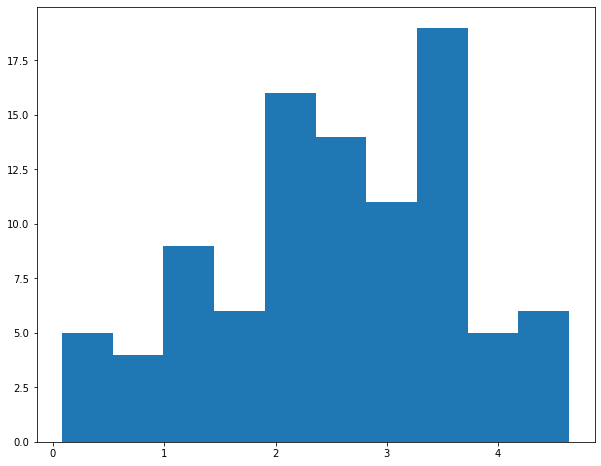

In [36]:
plt.hist(test_res)

In [37]:
np.mean(test_res)

2.565052631578948